In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin_tnc
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

### Linear Regression

In [2]:
def cost_func(theta, X, y, lambda_):
    m = X.shape[0]
    h = X @ theta
    J = (1 / (2*m)) * np.sum((h - y) ** 2)
    reg = (lambda_ / (2*m)) * np.sum(theta[1:] ** 2)
    J = J + reg
    
    delta = (1/m) * (X.T @ (h - y))
    grad = np.zeros((theta.shape))
    grad[0] = delta[0]
    grad[1:] = delta[1:] + (lambda_ / m) * theta[1:]
    return J, grad

In [3]:
class LinearRegression:
    def __init__(self, X, y):
        self.X = X.astype(float)
        self.y = y.astype(float)
        self.m = X.shape[0]            # no. of data
        self.n = X.shape[1]            # no. of features
        self.theta = np.zeros((self.n, 1))
    
    def fit(self, lambda_=0):
        self.theta = fmin_tnc(func=cost_func, x0=self.theta, args=(self.X, self.y.flatten(), lambda_))[0].reshape(self.n, 1)
        
    def predict(self, X_test):
        return X_test @ self.theta
    
    def get_cost(self, X, y):
        m = X.shape[0]
        h = X @ self.theta
        J = (1 / (2*m)) * np.sum((h - y) ** 2)
        return J

### Example (Bias and Variance)

In [4]:
mat = loadmat('..\datasets\ex5data1.mat')
X_train = mat['X']
y_train = mat['y']
X_val = mat['Xval']
y_val = mat['yval']
X_test = mat['Xtest']
y_test = mat['ytest']
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(12, 1) (12, 1)
(21, 1) (21, 1)
(21, 1) (21, 1)


In [5]:
# adding constant column
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_val = np.hstack((np.ones((X_val.shape[0], 1)), X_val))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

In [6]:
model = LinearRegression(X_train, y_train)
model.fit(lambda_=1)

In [7]:
y_pred = model.predict(X_test)
model.get_cost(X_test, y_test)

32.506665260467635

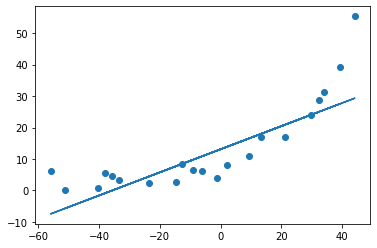

In [8]:
plt.scatter(X_test[:, 1], y_test)
plt.plot(X_test[:, 1], y_pred)

In [9]:
# Learning curve
def draw_learning_curve(X_train, y_train, X_val, y_val):
    m = X_train.shape[0]
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))

    for i in range(1, m+1):
        l_X_train = X_train[:i, :]
        l_y_train = y_train[:i, :]
        lr = LinearRegression(l_X_train, l_y_train)
        lr.fit(lambda_=1)
        error_train[i-1] = lr.get_cost(l_X_train, l_y_train)
        error_val[i-1] = lr.get_cost(X_val, y_val)

    plt.plot(np.arange(m), error_train, label='Train')
    plt.plot(np.arange(m), error_val, label='Cross Validation')
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

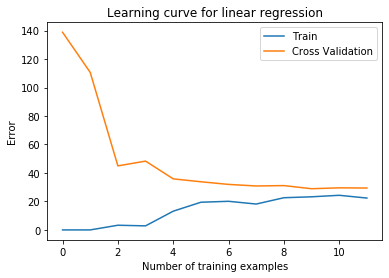

In [10]:
draw_learning_curve(X_train, y_train, X_val, y_val)

So, this model has high <b>Bias.</b>

Adding polynomial features (X, X<sup>2</sup>, , X<sup>3</sup>, ...) would be a good option.

But the features would be badly scaled (e.g., an example with x= 40 will now have a feature x<sub>8</sub>= 40<sup>8</sup>= 6.5×10<sup>12</sup>). So feature normalization is a must.

#### Adding Polynomial Features 

In [20]:
X_train = mat['X']
y_train = mat['y']
X_val = mat['Xval']
y_val = mat['yval']
X_test = mat['Xtest']
y_test = mat['ytest']
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(12, 1) (12, 1)
(21, 1) (21, 1)
(21, 1) (21, 1)


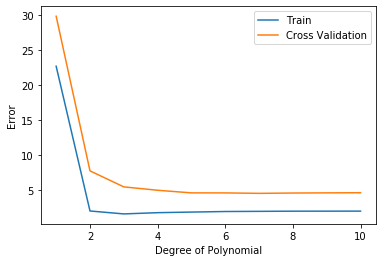

In [21]:
degree = 10
error_train = np.zeros((degree, 1))
error_val = np.zeros((degree, 1))

for d in range(1, degree+1):
    # Adding polynomial features
    poly = PolynomialFeatures(d)
    poly_X_train = poly.fit_transform(X_train)[:, 1:]
    poly_X_val = poly.fit_transform(X_val)[:, 1:]
    
    # Feature normalization
    scaler = StandardScaler()
    poly_X_train = scaler.fit_transform(poly_X_train)
    poly_X_val = scaler.fit_transform(poly_X_val)
    
    # Add Ones
    poly_X_train = np.hstack((np.ones((poly_X_train.shape[0], 1)), poly_X_train))
    poly_X_val = np.hstack((np.ones((poly_X_val.shape[0], 1)), poly_X_val))
    
    lr = LinearRegression(poly_X_train, y_train)
    lr.fit(lambda_=1)
    error_train[d-1] = lr.get_cost(poly_X_train, y_train)
    error_val[d-1] = lr.get_cost(poly_X_val, y_val)

plt.plot(np.arange(1, degree+1), error_train, label='Train')
plt.plot(np.arange(1, degree+1), error_val, label='Cross Validation')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Error')
plt.legend()
plt.show()

<b>degree = 8</b> seems sweet spot.

In [13]:
# Adding polynomial features
poly = PolynomialFeatures(8)
X_train = poly.fit_transform(X_train)[:, 1:]
X_val = poly.fit_transform(X_val)[:, 1:]
X_test = poly.fit_transform(X_test)[:, 1:]

# Feature normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

# Add Ones
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_val = np.hstack((np.ones((X_val.shape[0], 1)), X_val))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

In [14]:
model = LinearRegression(X_train, y_train)
model.fit(lambda_=1)

In [15]:
y_pred = model.predict(X_test)
model.get_cost(X_test, y_test)

7.851578582532761

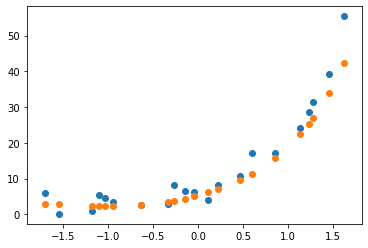

In [16]:
plt.scatter(X_test[:, 1], y_test)
plt.scatter(X_test[:, 1], y_pred)

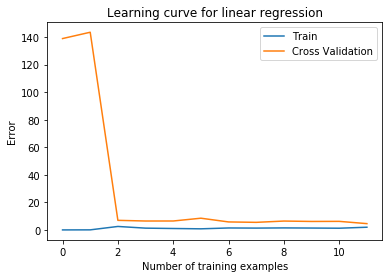

In [17]:
draw_learning_curve(X_train, y_train, X_val, y_val)